In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn, optim
from tqdm import tqdm


RESCALE_SIZE = 224

class PhoneDataset(Dataset):
    # Dataset class. __getItem__ returns pair image-label.
    # Image - torch.Tensor of shape [3, RESCALE_SIZE, RESCALE_SIZE].
    # Labels - {0, 1}. 1 Corresponds to image of a phone.
    def __init__(self, df):
        super().__init__()
        self.files = df['Image_File']
        self.labels = df['Label']  # !! Brand

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        label = self.labels[index]
        x = self.load_sample(self.files[index])
        x = self.prepare_sample(x)
        x = np.array(x / 255, dtype='float32')

        # RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=45),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        try:
            x = transform(x)
        except RuntimeError:
            x = np.array([x, x, x])
            x = x.reshape(-1, -1, 3)
            x = transform(x)
        return x, label

    @staticmethod
    def load_sample(file):
        image = Image.open(file)
        image.load()
        return image

    @staticmethod
    def prepare_sample(image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)


def correct_filename(filename: str):
    """
    Gets filename, leaves only ID of a photo.
    Applied to phone-images dataset only due to encoding errors in file names.
    :param filename: string of path to file from mobile_data_img.csv.
    :return: string with corrected filename
    """
    extra = re.search("_(.+?)\.", filename.split('/')[-1]).group(1)
    return filename.replace(extra, '')


def correct_names_in_df(data):
    """
    Corrects filenames in mobile_data_img.csv.
    :param data: pd.DataFrame from mobile_data_img.csv
    :return: corrected df.
    """
    print("Correct filenames...")
    data["Image_File"] = data["Image_File"].map(correct_filename)
    return data


def image_is_correct(file_path):
    img = PhoneDataset.load_sample(file_path)
    img = PhoneDataset.prepare_sample(img)
    img = np.array(img / 255, dtype='float32')
    if img.shape != (224, 224, 3):
        #print(img.shape)
        return False
    else:
        return True


def prepare_final_df(data, junk_df_path):
    """
    # Concat phone and "junk" photo into one dataset for binary classification.
    :param data:
    :param junk_df_path: "../data/junk_photo"
    :return: imbalanced dataset containing both phone- and junk- images.
    """
    print("Concatenate dataframes...")
    binary_task_df = pd.DataFrame(data["Image_File"])
    binary_task_df["Label"] = 1

    file_dict = {"Image_File": [], "Label": []}
    error_counter = 0
    for dirpath, dirs, files in os.walk(junk_df_path):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(dirpath, filename)
                if image_is_correct(file_path):
                    file_dict["Image_File"].append(file_path)
                    file_dict["Label"].append(0)
                else:
                    error_counter += 1
    junk_df = pd.DataFrame(file_dict)
    binary_task_df = pd.concat([binary_task_df, junk_df], axis=0, ignore_index=True)
    print("Number of incorrect images in junk files:", error_counter)
    return binary_task_df


def get_weighted_sampler(imbalanced_binary_df):
    """
    Dataset is highly imbalanced.
    Thus, we need weighted sampler to solve this problem on dataloader step.
    :param imbalanced_binary_df: pd.Dataframe, consists of rows: image_filename - label {0, 1}.
    :return: a WeightedRandomSampler which would be given as a param to a DataLoader.
    """
    print("Calculate dataset weights...")
    imb_binary_dataset = PhoneDataset(imbalanced_binary_df)
    v_counts = imbalanced_binary_df["Label"].value_counts()

    class_weights = {label: 1. / c for label, c in v_counts.items()}
    sample_weights = [0] * len(imb_binary_dataset)
    with tqdm(total=len(imb_binary_dataset)) as pbar_outer:
        for i, (data, label) in enumerate(imb_binary_dataset):
            class_weight = class_weights.get(label)
            sample_weights[i] = class_weight
            pbar_outer.update(1)
            if i == len(imb_binary_dataset) - 1:
                break
    return WeightedRandomSampler(sample_weights, num_samples=2 * len(imb_binary_dataset))


def count_values(image_df, sampler=None):
    """
    Count number of classes in df, with different samplers (or None)
    :param image_df: pf.DataFrame: Image_File -> Label
    :param sampler: some sampler or None
    :return: pd.DataFrame of shape [1, 2].
    """
    print("Counting class samples...")
    print(' ')
    if sampler is None:
        plot_loader = DataLoader(PhoneDataset(image_df), batch_size=100, shuffle=True)
    else:
        plot_loader = DataLoader(PhoneDataset(image_df), batch_size=100, sampler=weighted_sampler)
    counter_list = [0, 0]
    with tqdm(total=len(plot_loader)) as pbar_outer:
        for _, labels in plot_loader:
            tp = torch.sum(labels) # True Positive
            counter_list[1] += tp
            counter_list[0] += 100 - tp
            pbar_outer.update(1)
    return counter_list # pd.DataFrame(np.array(counter_list), columns=["False", "True"])


def plot_class_balance(df_1, df_2):
    """
    Plots bar charts with class balances
    """
    print("Plotting class balance before & after applying weights...")
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
    ax[0].barh([0, 1], df_1) #
    ax[1].barh([0, 1], df_2)
    fig.tight_layout()
    plt.show()


In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_layer = nn.Sequential(
        nn.BatchNorm2d(in_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    
    def forward(self, x):
        x = self.conv_layer(x)
        return x
    
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = ConvBlock(in_channels = 3, out_channels = 8)
        self.conv2 = ConvBlock(in_channels = 8, out_channels = 16)
        self.conv3 = ConvBlock(in_channels = 16, out_channels = 32)
        self.conv4 = ConvBlock(in_channels = 32, out_channels = 64)
        self.conv5 = ConvBlock(in_channels = 64, out_channels = 96)
        self.out = nn.Linear(96 * 5 * 5, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [3]:
def plot_train_stats(hist):
    """
    Plots the statistic of train loops.
    Includes loss and accuracy values per train dataset and validation dataset.
    :param hist: list of tuples. Each tuple cosists of four values: train loss & accuracy, validation loss & accuracy.
    :return: None
    """
    loss, acc, val_loss, val_acc = zip(*hist)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].plot(loss, label="train_loss")
    ax[0].plot(val_loss, label="val_loss")
    ax[0].legend(loc='best')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")

    ax[1].plot(acc, label="train_acc")
    val_accuracy = [i.item() for i in val_acc]
    ax[1].plot(val_accuracy, label="val_acc")
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy")
    plt.show()

In [4]:
    # Paths and prerequisites.
    meta_df = pd.read_csv("/kaggle/input/phone-classifier-set/data/4k_mobile_images/mobile_data_img.csv")
    IMG_URL = "/kaggle/input/phone-classifier-set/data/4k_mobile_images/"
    JUNK_IMG_URL = "/kaggle/input/phone-classifier-set/data/junk_photo"
    RESCALE_SIZE = 224
    meta_df.Image_File = IMG_URL + meta_df.Image_File
    if torch.cuda.is_available():
        print("Train on GPU...")
        DEVICE = torch.device('cuda')
    else:
        print("Train on CPU, CUDA not available")
        DEVICE = torch.device('cpu')

    # Preprocess data
    meta_df = correct_names_in_df(meta_df)
    binary_df = prepare_final_df(meta_df, JUNK_IMG_URL)
    #binary_df = binary_df.reset_index()
    train_dataframe, val_dataframe = train_test_split(binary_df, train_size=0.8, shuffle=False)
    val_dataframe = val_dataframe.reset_index()
    # Set pretrained model and its fc-layers.
    weighted_sampler = get_weighted_sampler(train_dataframe)
    

Train on GPU...
Correct filenames...
Concatenate dataframes...
Number of incorrect images in junk files: 75
Calculate dataset weights...


100%|██████████| 10276/10276 [01:23<00:00, 123.02it/s]


In [5]:
def train(train_df, val_df,
          model, optimizer, criterion,
          sampler=None,
          batch_size=16,
          epochs=10,
          device = torch.device('cpu')):
  
    train_dataset = PhoneDataset(train_df)
    val_dataset = PhoneDataset(val_df)
    # train loop:
    if sampler is None:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            # fit loop
            (print("train_loop №{}".format(epoch)))
            model.train()
            tr_loss = 0.0
            tr_accuracy = 0.0
            tr_accuracy_norm = len(train_loader)
            for i, (x_batch, y_batch) in enumerate(train_loader):
                #print("Batch №{}".format(i))
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()

                outputs = model(x_batch)  # encode labels!!!!
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                tr_loss += loss.detach()

                preds = torch.argmax(outputs, 1)
                acc = torch.sum(preds == y_batch) / batch_size
                tr_accuracy += acc.detach()

            # evaluation loop
            (print("val_loop №{}".format(epoch)))
            model.eval()
            val_loss = 0.0
            val_accuracy = 0.0
            val_accuracy_norm = len(val_loader)
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(x_batch)
                    val_loss += criterion(outputs, y_batch)

                    preds = torch.argmax(outputs, 1)
                    acc = torch.sum(preds == y_batch) / batch_size
                    val_accuracy += acc.detach()
            tr_loss = tr_loss/tr_accuracy_norm
            val_loss = val_loss/val_accuracy_norm
            tr_accuracy = tr_accuracy/tr_accuracy_norm
            val_accuracy = val_accuracy/val_accuracy_norm
            history.append((tr_loss.to('cpu').numpy(),
                            tr_accuracy.to('cpu').numpy(),
                            val_loss.to('cpu').numpy(),
                            val_accuracy.to('cpu').numpy()))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=tr_loss,
                                           v_loss=val_loss, t_acc=tr_accuracy, v_acc=val_accuracy))

    return history

In [11]:
  pretrained_model = SimpleCNN(n_classes=2) # models.resnet18(pretrained=True) #SimpleCNN(n_classes=2) # 


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train_loop №0
val_loop №0


epoch:   7%|▋         | 1/15 [01:49<25:32, 109.43s/it]


Epoch 001 train_loss: 0.1374     val_loss 0.4475 train_acc 0.9520 val_acc 0.8704
train_loop №1
val_loop №1


epoch:  13%|█▎        | 2/15 [03:35<23:13, 107.22s/it]


Epoch 002 train_loss: 0.0637     val_loss 0.4603 train_acc 0.9791 val_acc 0.8920
train_loop №2
val_loop №2


epoch:  20%|██        | 3/15 [05:21<21:20, 106.73s/it]


Epoch 003 train_loss: 0.0585     val_loss 0.4337 train_acc 0.9816 val_acc 0.8854
train_loop №3
val_loop №3


epoch:  27%|██▋       | 4/15 [07:06<19:27, 106.14s/it]


Epoch 004 train_loss: 0.0459     val_loss 0.3217 train_acc 0.9857 val_acc 0.9005
train_loop №4
val_loop №4


epoch:  33%|███▎      | 5/15 [08:55<17:53, 107.33s/it]


Epoch 005 train_loss: 0.0428     val_loss 0.2567 train_acc 0.9848 val_acc 0.9217
train_loop №5
val_loop №5


epoch:  40%|████      | 6/15 [10:46<16:14, 108.31s/it]


Epoch 006 train_loss: 0.0339     val_loss 0.1796 train_acc 0.9874 val_acc 0.9541
train_loop №6
val_loop №6


epoch:  47%|████▋     | 7/15 [12:35<14:28, 108.53s/it]


Epoch 007 train_loss: 0.0311     val_loss 0.2588 train_acc 0.9886 val_acc 0.9306
train_loop №7
val_loop №7


epoch:  53%|█████▎    | 8/15 [14:23<12:40, 108.60s/it]


Epoch 008 train_loss: 0.0325     val_loss 0.1143 train_acc 0.9883 val_acc 0.9599
train_loop №8
val_loop №8


epoch:  60%|██████    | 9/15 [16:12<10:52, 108.69s/it]


Epoch 009 train_loss: 0.0419     val_loss 0.1396 train_acc 0.9867 val_acc 0.9564
train_loop №9
val_loop №9


epoch:  67%|██████▋   | 10/15 [17:59<08:59, 108.00s/it]


Epoch 010 train_loss: 0.0306     val_loss 0.1383 train_acc 0.9896 val_acc 0.9529
train_loop №10
val_loop №10


epoch:  73%|███████▎  | 11/15 [19:44<07:08, 107.12s/it]


Epoch 011 train_loss: 0.0216     val_loss 0.2527 train_acc 0.9915 val_acc 0.9379
train_loop №11
val_loop №11


epoch:  80%|████████  | 12/15 [21:30<05:20, 106.76s/it]


Epoch 012 train_loss: 0.0243     val_loss 0.1712 train_acc 0.9899 val_acc 0.9525
train_loop №12
val_loop №12


epoch:  87%|████████▋ | 13/15 [23:16<03:33, 106.52s/it]


Epoch 013 train_loss: 0.0238     val_loss 0.2496 train_acc 0.9903 val_acc 0.9379
train_loop №13
val_loop №13


epoch:  93%|█████████▎| 14/15 [25:01<01:46, 106.15s/it]


Epoch 014 train_loss: 0.0229     val_loss 0.1835 train_acc 0.9903 val_acc 0.9398
train_loop №14
val_loop №14


epoch: 100%|██████████| 15/15 [26:47<00:00, 107.20s/it]



Epoch 015 train_loss: 0.0195     val_loss 0.1231 train_acc 0.9920 val_acc 0.9630


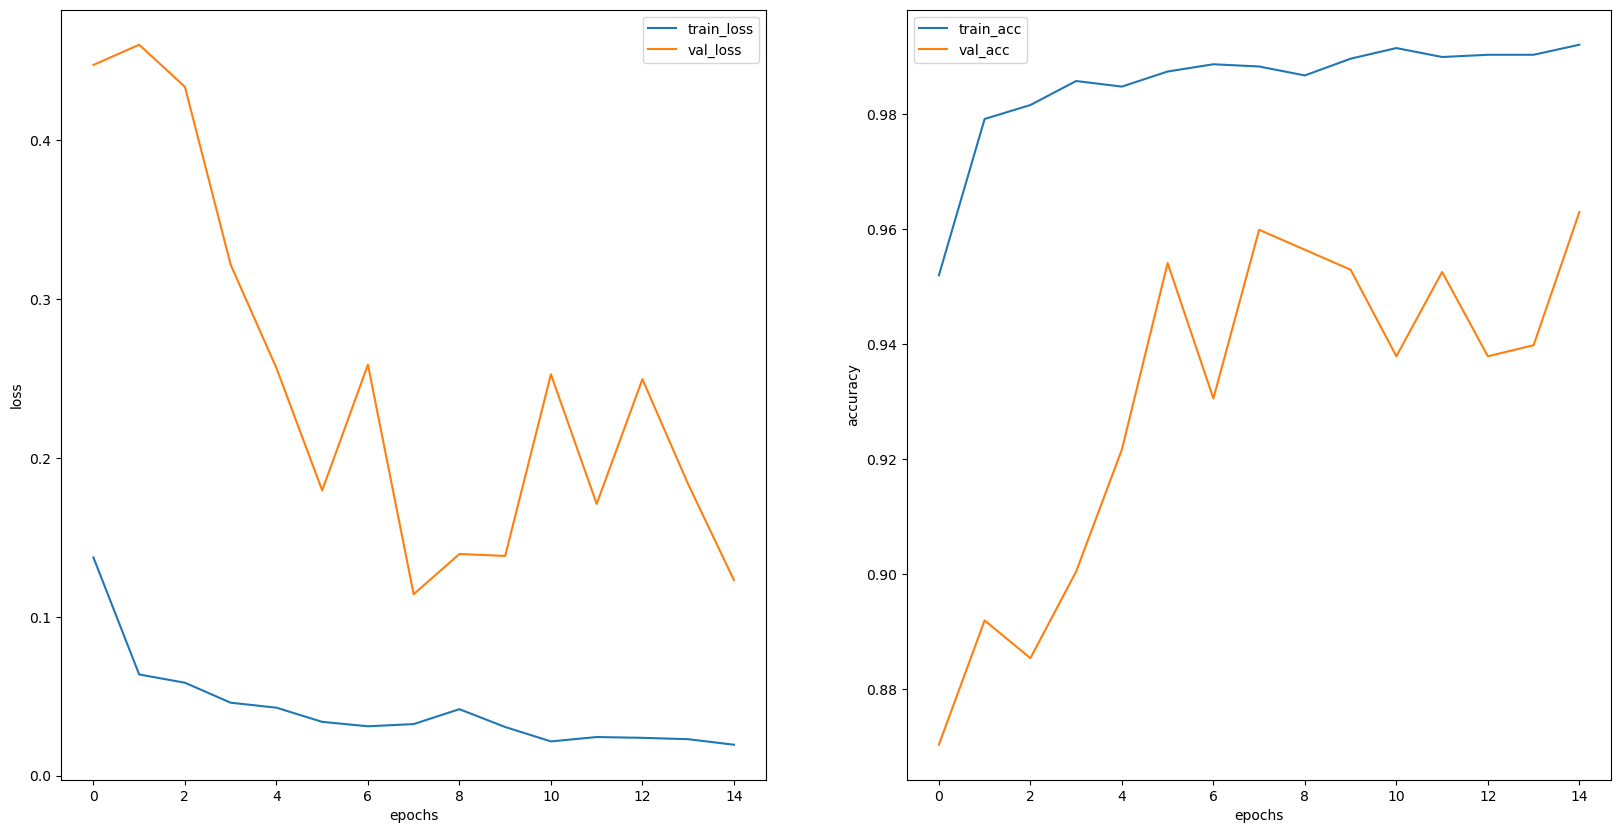

In [12]:
'''fc_intro_features = pretrained_model.fc.in_features
num_classes = 2
pretrained_model.fc = nn.Sequential(nn.Linear(fc_intro_features, num_classes)) #, 256),
                                        #nn.BatchNorm1d(256),
                                        #nn.Linear(256
'''
# Set parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Training begins!
pretrained_model.to(DEVICE)
history = train(train_dataframe,
                    val_dataframe,
                    model=pretrained_model,
                    optimizer=optimizer,
                    criterion=criterion,
                    batch_size=32,
                    epochs = 15,
                    device=DEVICE)
plot_train_stats(history)

checkpoint = {
       'model': pretrained_model,
        'state_dict': pretrained_model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

In [10]:
torch.save(checkpoint, '/kaggle/working/model_resnet18.pth')